# `BUILDING A REGRESSION MODEL TO FORECAST SALES` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to forecast the demand of products in various locations.

#### `Null Hypothesis`
There is no relationship between the average sales and the average sales of the various branches

#### `Alternate Hypothesis`
There is a relationship between the average sales and the average sales of the various branches

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;





#### `Analytical Questions`

- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## `Data Understanding`

#### Data Source
The data was sourced from three places:
- Three tables from Corporation Favorita's database 
- Two csv files from a OneDrive location
- Two csv files from a GitHub repository 
 

#### Data Features

- store_nbr : Identifies the store at which the products are sold.

- family : identifies the type of product sold.

- sales : gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- onpromotion : gives the total number of items in a product family that were being promoted at a store at a given date.

#### Data Exploration

##### `Libraries`

In [87]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
import plotly.express as px
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

##### `Database Connection`

In [52]:
#Access protocols for the SQL Database
env_variables = dotenv_values('logins.env')
database = env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [53]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [54]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM oil"

oil_df = pd.read_sql(query, connection,parse_dates= 'date')#,index_col=['date'])
oil_df.info
oil_df.head(5)

C:\Users\chrap\AppData\Local\Temp\ipykernel_16300\4104283356.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [55]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM holidays_events"

hdays_df = pd.read_sql(query, connection,parse_dates='date')
hdays_df.info
hdays_df.head(5)

C:\Users\chrap\AppData\Local\Temp\ipykernel_16300\3448575621.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [56]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM stores"

stores_df= pd.read_sql(query, connection,index_col='store_nbr')
stores_df.head(10)

C:\Users\chrap\AppData\Local\Temp\ipykernel_16300\2396760787.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
6,Quito,Pichincha,D,13
7,Quito,Pichincha,D,8
8,Quito,Pichincha,D,8
9,Quito,Pichincha,B,6


In [57]:
##Accessing the csv data 
sales_df = pd.read_csv("data\\store-sales-forecasting\\train.csv",parse_dates = ['date'])
sales_df.tail(10)

,id,date,store_nbr,family,sales,onpromotion
3000878,3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,3000879,2017-08-15,9,MEATS,449.228,0
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000,0
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [58]:
##Accessing the csv data 
transact_df = pd.read_csv("data\\store-sales-forecasting\\transactions.csv",parse_dates = ['date'])
transact_df.head(10)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [ ]:
## Call the train dataframe

train_df=pd.read

### DATA UNDERSTANDING

In [59]:
#Checking for missing values
oil_df.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

### EDA

In [60]:
### finding missing days in the sales data
sales_df.isnull().sum()

start_day = sales_df.date.min()
end_day = sales_df.date.max()

print(f'{start_day} \n\n {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_dates_sales = existing_date[~existing_date.isin(sales_df.index)]
print(missing_dates_sales)

2013-01-01 00:00:00 

 2017-08-15 00:00:00
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')


#Lets look for trends,seasonality and cyclic in each df


In [61]:
# Function to get the day name from a date string
from dateutil.parser import parse

def get_day_name(date_str):
    return date_str.strftime('%A')


day_names = []
# Get day names for each specific date
for date in missing_dates_sales:
    day = get_day_name(date)
    day_names.append(day)


print("Day names for specific dates:")
for date, day_name in zip(missing_dates_sales, day_names):
    print(f"{date}: {day_name}")

# Create a DataFrame for missing dates
missing_dates_df = pd.DataFrame({'date': pd.to_datetime(missing_dates_sales)})
    

Day names for specific dates:
2013-01-01 00:00:00: Tuesday
2013-01-02 00:00:00: Wednesday
2013-01-03 00:00:00: Thursday
2013-01-04 00:00:00: Friday
2013-01-05 00:00:00: Saturday
2013-01-06 00:00:00: Sunday
2013-01-07 00:00:00: Monday
2013-01-08 00:00:00: Tuesday
2013-01-09 00:00:00: Wednesday
2013-01-10 00:00:00: Thursday
2013-01-11 00:00:00: Friday
2013-01-12 00:00:00: Saturday
2013-01-13 00:00:00: Sunday
2013-01-14 00:00:00: Monday
2013-01-15 00:00:00: Tuesday
2013-01-16 00:00:00: Wednesday
2013-01-17 00:00:00: Thursday
2013-01-18 00:00:00: Friday
2013-01-19 00:00:00: Saturday
2013-01-20 00:00:00: Sunday
2013-01-21 00:00:00: Monday
2013-01-22 00:00:00: Tuesday
2013-01-23 00:00:00: Wednesday
2013-01-24 00:00:00: Thursday
2013-01-25 00:00:00: Friday
2013-01-26 00:00:00: Saturday
2013-01-27 00:00:00: Sunday
2013-01-28 00:00:00: Monday
2013-01-29 00:00:00: Tuesday
2013-01-30 00:00:00: Wednesday
2013-01-31 00:00:00: Thursday
2013-02-01 00:00:00: Friday
2013-02-02 00:00:00: Saturday
2013-0

In [62]:
### Adding the missing dates to the dataframe
# Merge with specific dates to include missing dates
sales_df = sales_df.reset_index(drop=False)
sales_df = pd.concat([sales_df, missing_dates_df], ignore_index=True)
sales_df

,index,id,date,store_nbr,family,sales,onpromotion
0,0.0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,1.0,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2.0,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0
3,3.0,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,4.0,4.0,2013-01-01,1.0,BOOKS,0.0,0.0
...,...,...,...,...,...,...,...
3002571,NaN,NaN,2017-08-11,NaN,NaN,NaN,NaN
3002572,NaN,NaN,2017-08-12,NaN,NaN,NaN,NaN
3002573,NaN,NaN,2017-08-13,NaN,NaN,NaN,NaN
3002574,NaN,NaN,2017-08-14,NaN,NaN,NaN,NaN


In [63]:
### Merging the sales and oil dataframes
combined_df = pd.merge(sales_df, oil_df , on='date', how='left') 
                       

In [64]:
### Merging the sales ,stores and oil dataframes
combined_df = pd.merge(combined_df, stores_df, on='store_nbr', how='left')
combined_df.head(5)

,index,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,0.0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0
1,1.0,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0
2,2.0,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0
3,3.0,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13.0
4,4.0,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13.0


In [65]:
### Merging the sales,holidays and oil dataframes
combined_hso_df = pd.merge(combined_df, hdays_df , on='date', how='left') 
combined_hso_df.head(10)

,index,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0.0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
1,1.0,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
2,2.0,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
3,3.0,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
4,4.0,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
5,5.0,5.0,2013-01-01,1.0,BREAD/BAKERY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
6,6.0,6.0,2013-01-01,1.0,CELEBRATION,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
7,7.0,7.0,2013-01-01,1.0,CLEANING,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
8,8.0,8.0,2013-01-01,1.0,DAIRY,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False
9,9.0,9.0,2013-01-01,1.0,DELI,0.0,0.0,NaN,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Primer dia del ano,False


In [66]:
### finding missing days in the sales data
transact_df.isnull().sum()

start_day = transact_df.index.min()
end_day = transact_df.index.max()

print(f'{start_day} \n\n {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_dates = existing_date[~existing_date.isin(transact_df.index)]
print(missing_dates)

0 

 83487
DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')


In [67]:
#Checking for missing values
combined_hso_df.isnull().sum()

index             1718
id                1718
date                 0
store_nbr         1718
family            1718
sales             1718
onpromotion       1718
dcoilwtico      955692
city              1718
state             1718
type_x            1718
cluster           1718
type_y         2553256
locale         2553256
locale_name    2553256
description    2553256
transferred    2553256
dtype: int64

In [68]:
combined_eda= combined_hso_df.copy()

combined_eda.dropna()

,index,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
73062,73062.0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.000,0.0,97.010002,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Carnaval,False
73063,73063.0,73063.0,2013-02-11,1.0,BABY CARE,0.000,0.0,97.010002,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Carnaval,False
73064,73064.0,73064.0,2013-02-11,1.0,BEAUTY,0.000,0.0,97.010002,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Carnaval,False
73065,73065.0,73065.0,2013-02-11,1.0,BEVERAGES,172.000,0.0,97.010002,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Carnaval,False
73066,73066.0,73066.0,2013-02-11,1.0,BOOKS,0.000,0.0,97.010002,Quito,Pichincha,D,13.0,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883.0,3000883.0,2017-08-15,9.0,POULTRY,438.133,0.0,47.570000,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884.0,3000884.0,2017-08-15,9.0,PREPARED FOODS,154.553,1.0,47.570000,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885.0,3000885.0,2017-08-15,9.0,PRODUCE,2419.729,148.0,47.570000,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886.0,3000886.0,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000,8.0,47.570000,Quito,Pichincha,B,6.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [69]:
combined_hso_df['dcoilwtico'] = combined_hso_df['dcoilwtico'].bfill()
combined_hso_df['onpromotion'] = combined_hso_df['onpromotion'].fillna(0)
combined_hso_df['transferred'] = combined_hso_df['transferred'].fillna(False)
combined_hso_df['description'] = combined_hso_df['description'].fillna('None')
combined_hso_df['locale'] = combined_hso_df['locale'].fillna('None')
combined_hso_df['locale_name'] = combined_hso_df['locale_name'].fillna('None')
combined_hso_df['type_y'] = combined_hso_df['type_y'].fillna('None')
combined_hso_df['type_x'] = combined_hso_df['type_x'].fillna('None')
combined_hso_df['sales'] = combined_hso_df['sales'].fillna(0)
combined_hso_df['store_nbr'] = combined_hso_df['store_nbr'].fillna(0)
combined_hso_df['family'] = combined_hso_df['family'].fillna('None')
combined_hso_df['city'] = combined_hso_df['city'].fillna('None')
combined_hso_df['state'] = combined_hso_df['state'].fillna('None')
combined_hso_df['cluster'] = combined_hso_df['cluster'].fillna(0)

C:\Users\chrap\AppData\Local\Temp\ipykernel_16300\1914279937.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [70]:
#Checking for missing values
combined_hso_df.isnull().sum()

index          1718
id             1718
date              0
store_nbr         0
family            0
sales             0
onpromotion       0
dcoilwtico        0
city              0
state             0
type_x            0
cluster           0
type_y            0
locale            0
locale_name       0
description       0
transferred       0
dtype: int64

In [71]:
# function to create the year,month and days
def calender(df): 

    df['monthname'] = df['date'].dt.month_name()
    df['dayname'] = df['date'].dt.day_name()
    df['day']= df['date'].dt.day
    df['year'] = df['date'].dt.year

    return df

In [73]:
combined_hso_df = calender (combined_hso_df)
combined_eda = calender(combined_eda)

In [ ]:
combined_hso_df

,index,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,...,cluster,type_y,locale,locale_name,description,transferred,monthname,dayname,day,year
0,0.0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,93.139999,Quito,Pichincha,...,13.0,Holiday,National,Ecuador,Primer dia del ano,False,January,Tuesday,1,2013
1,1.0,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0,93.139999,Quito,Pichincha,...,13.0,Holiday,National,Ecuador,Primer dia del ano,False,January,Tuesday,1,2013
2,2.0,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0,93.139999,Quito,Pichincha,...,13.0,Holiday,National,Ecuador,Primer dia del ano,False,January,Tuesday,1,2013
3,3.0,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0,93.139999,Quito,Pichincha,...,13.0,Holiday,National,Ecuador,Primer dia del ano,False,January,Tuesday,1,2013
4,4.0,4.0,2013-01-01,1.0,BOOKS,0.0,0.0,93.139999,Quito,Pichincha,...,13.0,Holiday,National,Ecuador,Primer dia del ano,False,January,Tuesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056061,NaN,NaN,2017-08-11,0.0,None,0.0,0.0,48.810001,None,None,...,0.0,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,August,Friday,11,2017
3056062,NaN,NaN,2017-08-12,0.0,None,0.0,0.0,47.590000,None,None,...,0.0,None,None,None,None,False,August,Saturday,12,2017
3056063,NaN,NaN,2017-08-13,0.0,None,0.0,0.0,47.590000,None,None,...,0.0,None,None,None,None,False,August,Sunday,13,2017
3056064,NaN,NaN,2017-08-14,0.0,None,0.0,0.0,47.590000,None,None,...,0.0,None,None,None,None,False,August,Monday,14,2017


In [74]:
combined_hso_df_2= combined_hso_df.set_index('date')
combined_eda = combined_eda.set_index('date')

#### Univariate Analysis

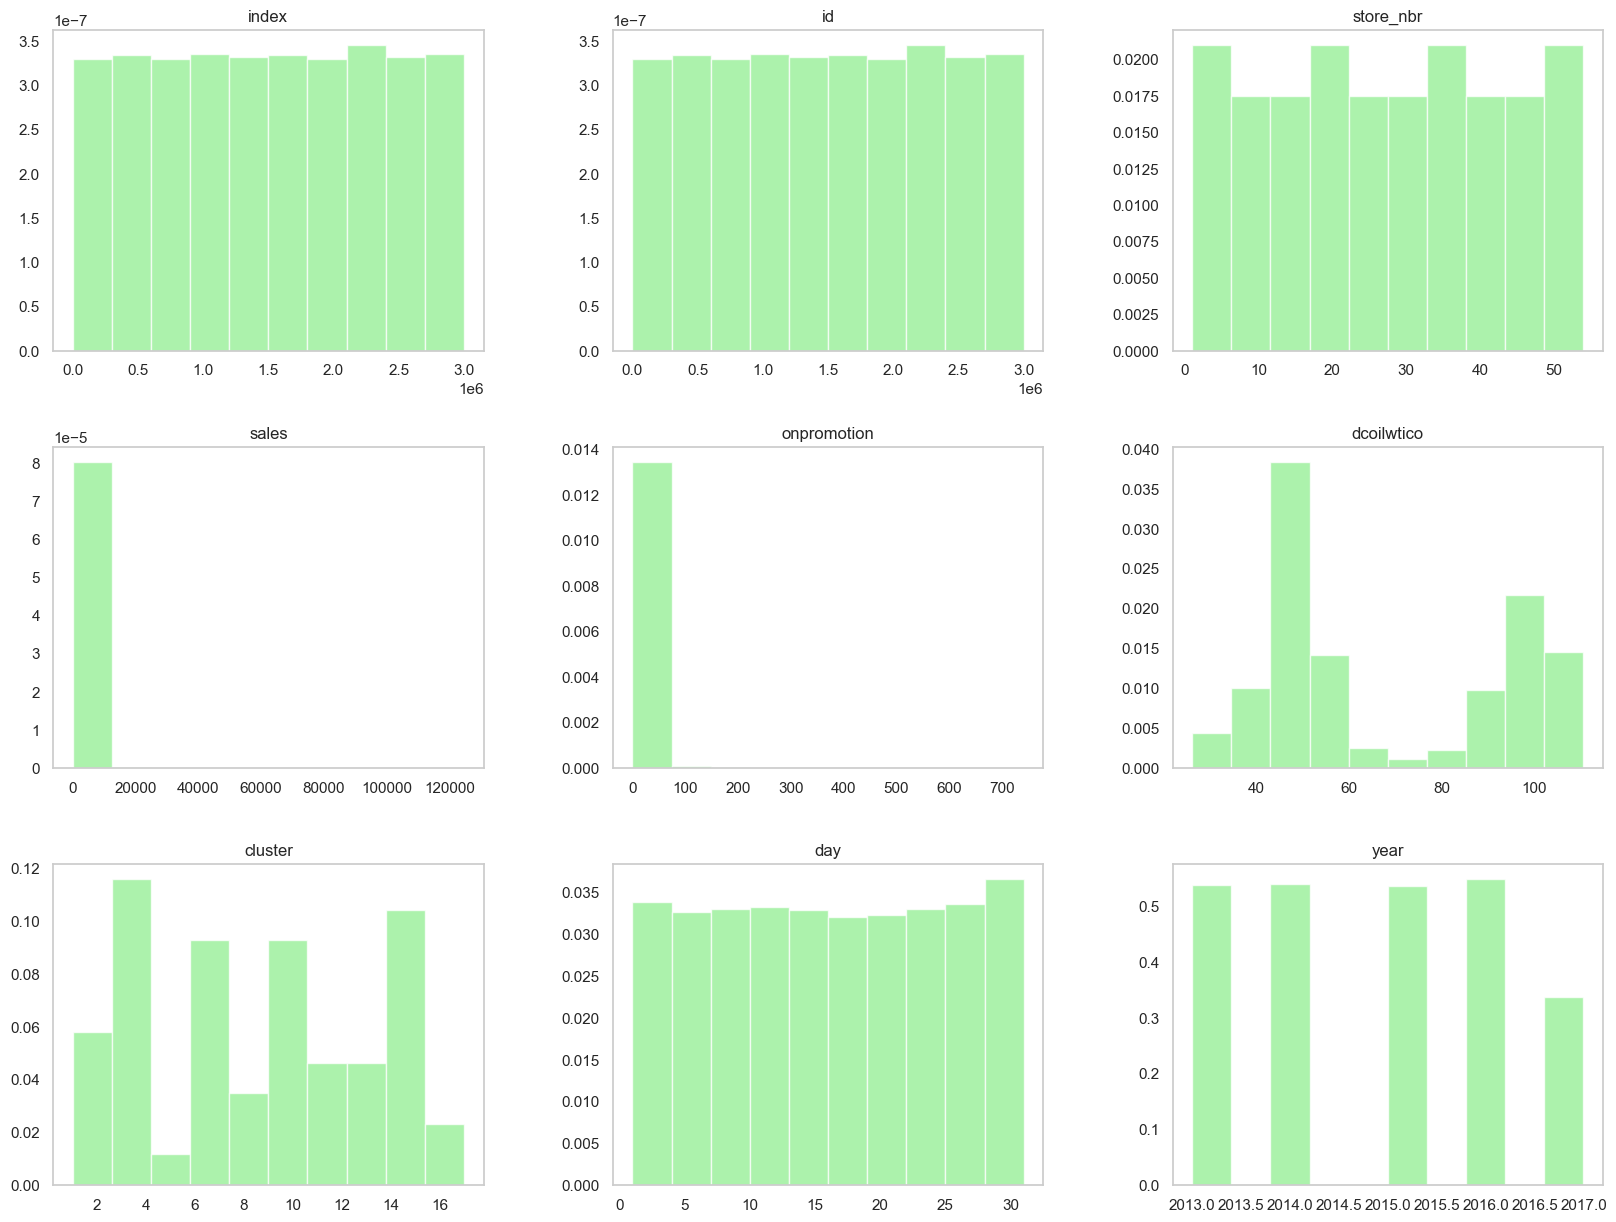

In [75]:
# Distribution of the variables
combined_eda.hist(density = True,figsize = (20, 15), facecolor = 'seablue', alpha = 0.75,grid = False)

plt.show()

<Axes: xlabel='sales', ylabel='Density'>

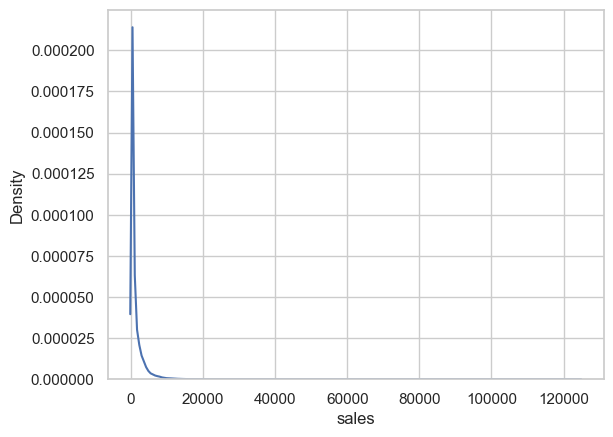

In [76]:
sns.kdeplot(combined_eda['sales'])

#### Observation
- Sales is left skewed

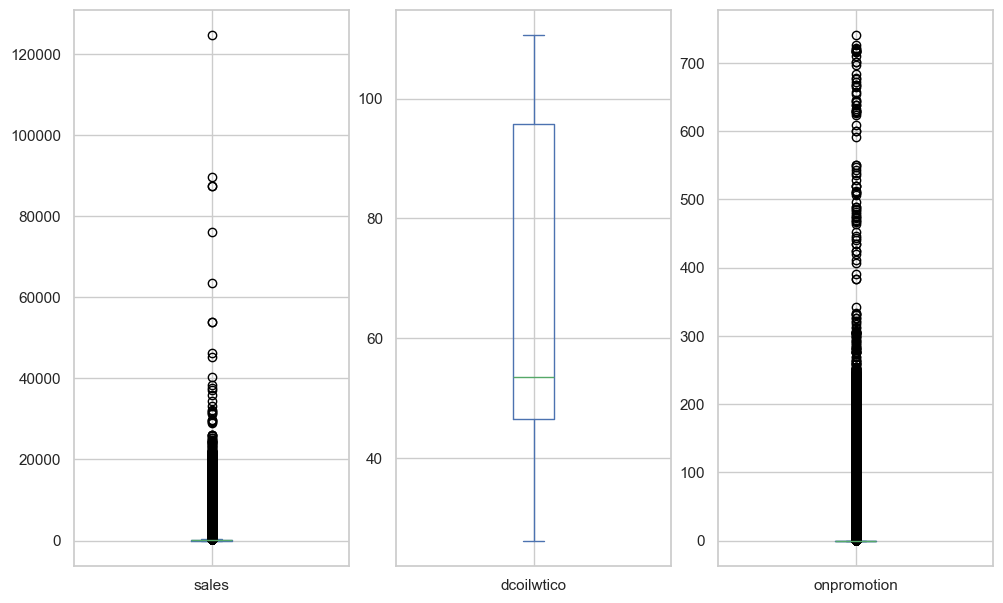

In [77]:
plt.subplot(131)
combined_eda['sales'].plot.box(figsize=(10,6))
plt.tight_layout(pad=0.5)
plt.subplot(132)
combined_eda['dcoilwtico'].plot.box()
plt.tight_layout(pad=0.5)
plt.subplot(133)
combined_eda['onpromotion'].plot.box()
plt.tight_layout(pad=0.5)

##### Observation

- A lot of outliers in sales and promotions

##### BiVariate Analysis

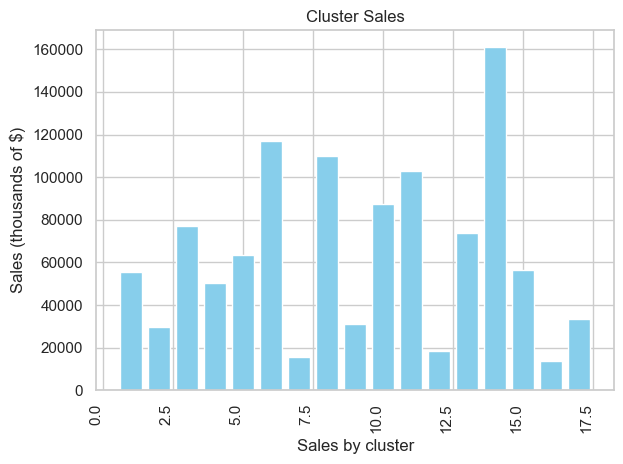

In [78]:
cluster_sales= (combined_eda.groupby('cluster')['sales'].sum()/1000).sort_values(ascending=True)
plt.bar(cluster_sales.index, cluster_sales, color='skyblue')
plt.xlabel('Sales by cluster')
plt.ylabel('Sales (thousands of $)')
plt.title('Cluster Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


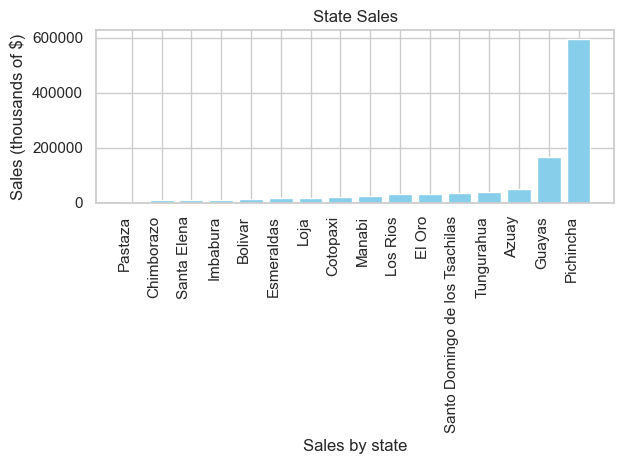

In [79]:
state_sales= (combined_eda.groupby('state')['sales'].sum()/1000).sort_values(ascending=True)
plt.bar(state_sales.index, state_sales, color='skyblue')
plt.xlabel('Sales by state')
plt.ylabel('Sales (thousands of $)')
plt.title('State Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

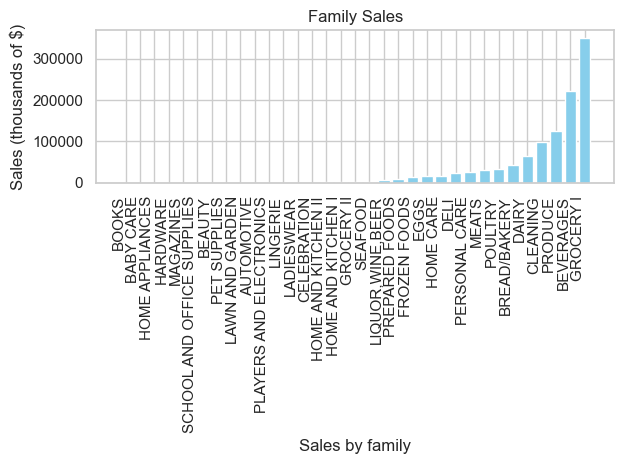

In [80]:
family_sales= (combined_eda.groupby('family')['sales'].sum()/1000).sort_values(ascending=True)
plt.bar(family_sales.index, family_sales, color='skyblue')
plt.xlabel('Sales by family')
plt.ylabel('Sales (thousands of $)')
plt.title('Family Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

#### Analytical Questions

#### Q1 Is the train dataset complete (has all the required dates)?


In [ ]:
#missing dates in sales
missing_dates_sales


DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

##### Observation

- Train Dataset is not complete, the sales column has 1688 missing days
- There is no earthquake data

##### Q2 Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


In [ ]:
#Taking out all the zero values
non_zero_values = combined_hso_df_2[combined_hso_df_2.sales != 0]
unique_years= combined_hso_df.year.unique()
unique_years

data = pd.DataFrame(columns=['year', 'min_sales_date', 'max_sales_date'])

for d in unique_years:
    year= non_zero_values[non_zero_values.year == d]
    min_index = year.sales.idxmin()
    max_index= year.sales.idxmax()
    #thisdict = dict(year = d, min_sales_date = min_index, max_sales_date = max_index)
    #for row in thisdict:
    data.loc[len(data)] = d,min_index,max_index
    #print(f'Year   Min_Sales_date    Max_Sales_date \n {d} {min_index} {max_index}')

data

,year,min_sales_date,max_sales_date
0,2013,2013-08-06,2013-11-12
1,2014,2014-12-05,2014-12-08
2,2015,2015-09-15,2015-12-14
3,2016,2016-06-23,2016-05-02
4,2017,2017-02-09,2017-04-02


#### Observation
From the data given : 
- From 2013-2015 ,the company had its maximum sales in December. 
- From 2016 - 2017 ,the company had its maximum sales mid-year

#### Q3 Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [ ]:
###resample or groupby

# Downsample to monthly data by taking the mean
monthly_data = combined_hso_df_2.sales.resample('ME').sum()



fig = px.line(monthly_data, x=monthly_data.index, y='sales', title='Yearly Sales Trend')

# Show the plot
fig.show()

##### Observation
- Deember 2016 had the highest sales of $ 30.77 million

Did the earthquake impact sales?


In [ ]:
#Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


#### Q5 Are sales affected by promotions, oil prices and holidays?


In [81]:
promotions_holiday_df = combined_hso_df_2[(combined_hso_df_2.onpromotion > 0) | (combined_hso_df_2.type_y == 'Holiday')]
straight_day_df = combined_hso_df_2[(combined_hso_df_2.onpromotion == 0) & (combined_hso_df_2.type_y != 'Holiday')]

#fig = px.line(promotions_holiday_df , x=promotions_holiday_df.index, y='sales', title='Yearly Sales Trend')
##fig = px.line(straight_day_df , x=straight_day_df.index, y='sales', title='Yearly Sales Trend')
# Show the plot
#fig.show()


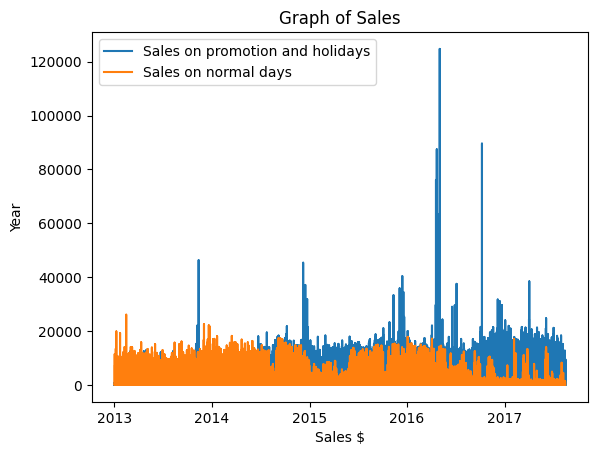

In [ ]:
# Plotting
plt.plot(promotions_holiday_df.index, promotions_holiday_df.sales, label='Sales on promotion and holidays')
plt.plot(straight_day_df.index, straight_day_df.sales, label='Sales on normal days')

# Customize the plot (optional)
plt.xlabel('Sales $')
plt.ylabel('Year')
plt.title('Graph of Sales')
plt.legend()

# Show the plot
plt.show()

#### Observation

- It can be clearly seen that sales are much higher on promotion days or holidays

In [ ]:
##What analysis can we get from the date and its extractable features?


#### Q7 Which product family and stores did the promotions affect.


In [82]:
promotions_df = combined_hso_df_2[combined_hso_df_2.onpromotion != 0]
promotions_df.head(3)

,index,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,monthname,dayname,day,year
date,,,,,,,,,,,,,,,,,,,,
2014-04-01,810784.0,810784.0,9.0,CLEANING,1752.0,3.0,99.690002,Quito,Pichincha,B,6.0,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,April,Tuesday,1,2014
2014-04-01,810789.0,810789.0,9.0,GROCERY I,7685.0,5.0,99.690002,Quito,Pichincha,B,6.0,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,April,Tuesday,1,2014
2014-04-02,812571.0,812571.0,9.0,GROCERY I,6481.0,3.0,99.599998,Quito,Pichincha,B,6.0,None,None,None,None,False,April,Wednesday,2,2014


In [83]:
promotions = promotions_df.groupby(['store_nbr','family'])['onpromotion'].count().sort_values(ascending=False)
promotions.head(50)

###### try and map the city and state to this to make it more clearer

store_nbr  family   
6.0        GROCERY I    1217
28.0       GROCERY I    1216
38.0       GROCERY I    1205
2.0        GROCERY I    1203
9.0        GROCERY I    1201
8.0        GROCERY I    1201
3.0        GROCERY I    1200
41.0       GROCERY I    1196
39.0       GROCERY I    1190
35.0       GROCERY I    1187
11.0       GROCERY I    1172
23.0       GROCERY I    1170
48.0       GROCERY I    1169
37.0       GROCERY I    1169
33.0       GROCERY I    1168
7.0        GROCERY I    1166
5.0        GROCERY I    1163
45.0       GROCERY I    1162
54.0       GROCERY I    1161
6.0        BEVERAGES    1160
27.0       GROCERY I    1159
4.0        GROCERY I    1157
47.0       GROCERY I    1156
44.0       GROCERY I    1155
11.0       BEVERAGES    1155
49.0       GROCERY I    1154
34.0       GROCERY I    1153
35.0       BEVERAGES    1153
8.0        BEVERAGES    1151
46.0       GROCERY I    1151
50.0       GROCERY I    1151
36.0       GROCERY I    1150
6.0        CLEANING     1150
3.0        BEVERAGES  

#### Observation

- Grocery family had the most promotion and this can be attributed to it being perishable items 
- Most promotions are in the Quito City in the Pichincha State

In [ ]:
#non_zero_values = combined_hso_df_2[combined_hso_df_2.sales != 0]

In [ ]:
#What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


#### Q9 Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [84]:
salary_days_df = combined_hso_df_2[(combined_hso_df_2.day == 15) | (combined_hso_df_2.day > 25)]
normal_days_df = combined_hso_df_2[(combined_hso_df_2.day != 15) | (combined_hso_df_2.day < 25)]

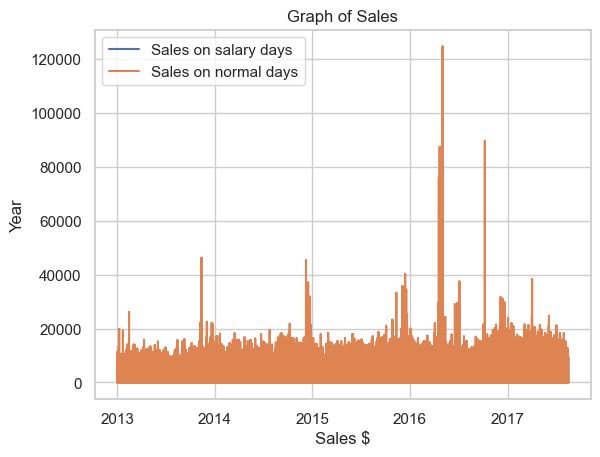

In [85]:
# Plotting
plt.plot(salary_days_df.index, salary_days_df.sales, label='Sales on salary days')
plt.plot(normal_days_df.index, normal_days_df.sales, label='Sales on normal days')

# Customize the plot (optional)
plt.xlabel('Sales $')
plt.ylabel('Year')
plt.title('Graph of Sales')
plt.legend()

# Show the plot
plt.show()

##### Observation
- Sales clearly doesnt depend on salary days

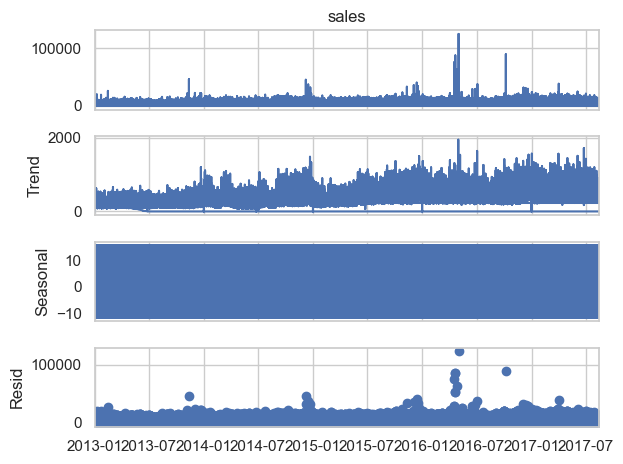

In [86]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
ts = combined_hso_df.set_index('date')['sales'] 
result = seasonal_decompose(ts, model='additive', period=365,extrapolate_trend= 'freq')
result.plot()
plt.show()

In [ ]:
### Test for Stationarity parametric tests for stationarity

In [ ]:
from statsmodels.tsa.seasonal import STL

# Assuming 'df' is your DataFrame with a datetime index
stl = STL(combined_hso_df_2.sales)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid


ValueError: Unable to determine period from endog

In [ ]:
from fbprophet import Prophet

# Fit Prophet model
model = Prophet()
model.fit(combined_hso_df_2.sales)
forecast = model.predict()

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
combined_hso_df['sales'] = combined_hso_df['sales'].fillna(0)

In [ ]:
combined_hsot_df = pd.merge(combined_hso_df,transact_df , on='date', how='left') 
combined_hsot_df.head(10)

MemoryError: Unable to allocate 6.78 GiB for an array with shape (6, 151571051) and data type object

In [ ]:
day_names = []
# Get day names for each specific date
for date in missing_dates:
    day = get_day_name(date)
    day_names.append(day)


print("Day names for specific dates:")
for date, day_name in zip(missing_dates, day_names):
    print(f"{date}: {day_name}")

# Create a DataFrame for missing dates
missing_dates_df = pd.DataFrame({'date': pd.to_datetime(missing_dates)})
    

Day names for specific dates:
2013-12-25 00:00:00: Wednesday
2014-12-25 00:00:00: Thursday
2015-12-25 00:00:00: Friday
2016-01-01 00:00:00: Friday
2016-01-03 00:00:00: Sunday
2016-12-25 00:00:00: Sunday


## Seasonality,trends and cyclic checks

Zivot-Andrews test for stationarity test

from statsmodels.tsa.stattools import zivot_andrews
t_stat, p_value, critical_values, _, _ = zivot_andrews(stationary_with_break[0].values)
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

### Observation
holidays only

#### Merging the sales,transactions and oil data

In [ ]:
# whole_df = pd.merge(combined_df, transact_df , on='date', how='left') 
# whole_df

In [ ]:
missing_dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [ ]:
# function to create the year,month and days
def calender(df): 
    try:
        df['monthname'] = df['date'].dt.month_name()
        df['dayname'] = df['date'].dt.day_name()
        df['year'] = df['date'].dt.year
    except KeyError:
        df['date'] = df.index
        df['monthname'] = df['date'].dt.month_name()
        df['dayname'] = df['date'].dt.day_name()
        df['year'] = df['date'].dt.year
    return df

In [ ]:
sales_df = calender(sales_df)
transact_df = calender(transact_df)
hdays_df = calender(hdays_df)
oil_df = calender(oil_df)


#### SALES

In [ ]:
# Graph of trends
patterns = ['W','ME','YE']

for pattern in patterns:
        #create new DataFrame
    resample_df = pd.DataFrame()

    #create 'sales' column that summarizes total sales by week
    resample_df['sales'] = sales_df['sales'].resample(pattern).sum()
    #plot weekly sales data
    
    fig = px.line(resample_df,x=resample_df.index, y=resample_df.sales) 
    fig.update_xaxes(
        rangeslider_visible = True,
        rangeselector = dict(
            buttons = list ([
dict(count = 1, label = 'Sect 1' , step = 'year' , stepmode = 'backward'),
dict(count = 2, label = 'Sect 2' , step = 'year' , stepmode = 'backward'),
dict(count = 3, label = 'Sect 3' , step = 'year' , stepmode = 'backward'),
dict(step = 'all')
            ])
        )
    )

    # Creating the Figure instance
 
# showing the plot
    fig.show()



TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

#### Transactions

# Graph of trends
patterns = ['W','M','A']

for pattern in patterns:
        #create new DataFrame
    resample_df = pd.DataFrame()

    #create 'sales' column that summarizes total sales by week
    resample_df['sales'] = transact_df['transactions'].resample(pattern).sum()
    #plot weekly sales data
    
    fig = px.line(x=resample_df.index, y=resample_df.sales) 

    # Creating the Figure instance
 
# showing the plot
    fig.show()

#### Observations

- There is seasonality in the monthly tranactions
- All other graphs are trending

### Checking for gaps in the data

In [ ]:
oil = oil_df.groupby('monthname')['dcoilwtico'].mean().sort_values()
oil

monthname
December     61.209884
November     64.062875
March        64.706759
January      65.082079
February     65.727708
August       67.323546
April        68.629231
June         70.277850
May          70.355377
October      70.963034
July         71.243238
September    72.134217
Name: dcoilwtico, dtype: float64

In [ ]:
#Checking for missing values
oil_df.isnull().sum()

dcoilwtico    43
date           0
monthname      0
dayname        0
year           0
dtype: int64

In [ ]:
#Checking for missing values
transact_df.isnull().sum()

store_nbr       0
transactions    0
date            0
monthname       0
dayname         0
year            0
dtype: int64

In [ ]:
#Checking for missing values
sales_df.isnull().sum()

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
date           0
monthname      0
dayname        0
year           0
dtype: int64

In [ ]:
#Checking for missing values
hdays_df.isnull().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
date           0
monthname      0
dayname        0
year           0
dtype: int64

#### Oil

# Graph of trends
patterns = ['W','M','A']

for pattern in patterns:
        #create new DataFrame
    resample_df = pd.DataFrame()

    #create 'sales' column that summarizes total sales by week
    resample_df['sales'] = oil_df['dcoilwtico'].resample(pattern).sum()
    #plot weekly sales data
    
    fig = px.line(x=resample_df.index, y=resample_df.sales) 

    # Creating the Figure instance
 
# showing the plot
    fig.show()

In [ ]:
# fig = px.line(sales_df, x=sales_df.index, y="sales")
# fig.show()

In [ ]:
# fig = px.line(transact_df, x=transact_df.index, y="transactions")
# fig.show()

In [ ]:
# import plotly.graph_objects as go

# # Create random data with numpy
# import numpy as np

# # Create traces
# fig = go.Figure()
# # fig.add_trace(go.Scatter(x=oil_df.date, y=oil_df.dcoilwtico,
# #                     mode='lines',
# #                     name='Oil Price over the years'))
# fig.add_trace(go.Scatter(x=sales_df.index, y=sales_df.sales,
#                     mode='lines+markers',
#                     name='Sales over the years'))
# # fig.add_trace(go.Scatter(x=transact_df.index, y=transact_df.transactions,
# #                     mode='markers', name='markers'))

# fig.show()